In [23]:
import sys
sys.path.append("..")
from pathlib import Path
import numpy as np
from scipy import stats
import importlib
import src.assay_calibration.fit_utils.two_sample.fit
from src.assay_calibration.fit_utils.fit import Fit
importlib.reload(src.assay_calibration.fit_utils.two_sample.fit)
importlib.reload(src.assay_calibration.fit_utils.fit)
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib
matplotlib.set_loglevel("warning")
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
import os
sys.path.append(str(Path(os.getcwd()).parent))
from src.assay_calibration.data_utils.dataset import (
    PillarProjectDataframe,
    Scoreset,
    BasicScoreset,
)
import json
import glob
import gzip
# Suppress matplotlib debug messages
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [43]:
constrained = True

save_dir = f'/data/ross/assay_calibration/constraint_comparison/{"un" if not constrained else ""}constrained_pngs'
os.makedirs(save_dir, exist_ok=True)

if constrained:
    results_name = 'initial_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
    
    results_name = 'clinvar_circ_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = {**results, **json.load(f)}

else:
    results_name = 'unconstrained_rerun_initial_datasets_results_1000bootstraps_100fits'
    with gzip.open(f'/data/ross/assay_calibration/{results_name}.json.gz', 'rt', encoding='utf-8') as f:
        results = json.load(f)
    

XRCC2_unpublished: 2957 total variants
	Pathogenic/Likely Pathogenic: 6 variants
	Benign/Likely Benign: 46 variants
	gnomAD: 514 variants
	Synonymous: 458 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


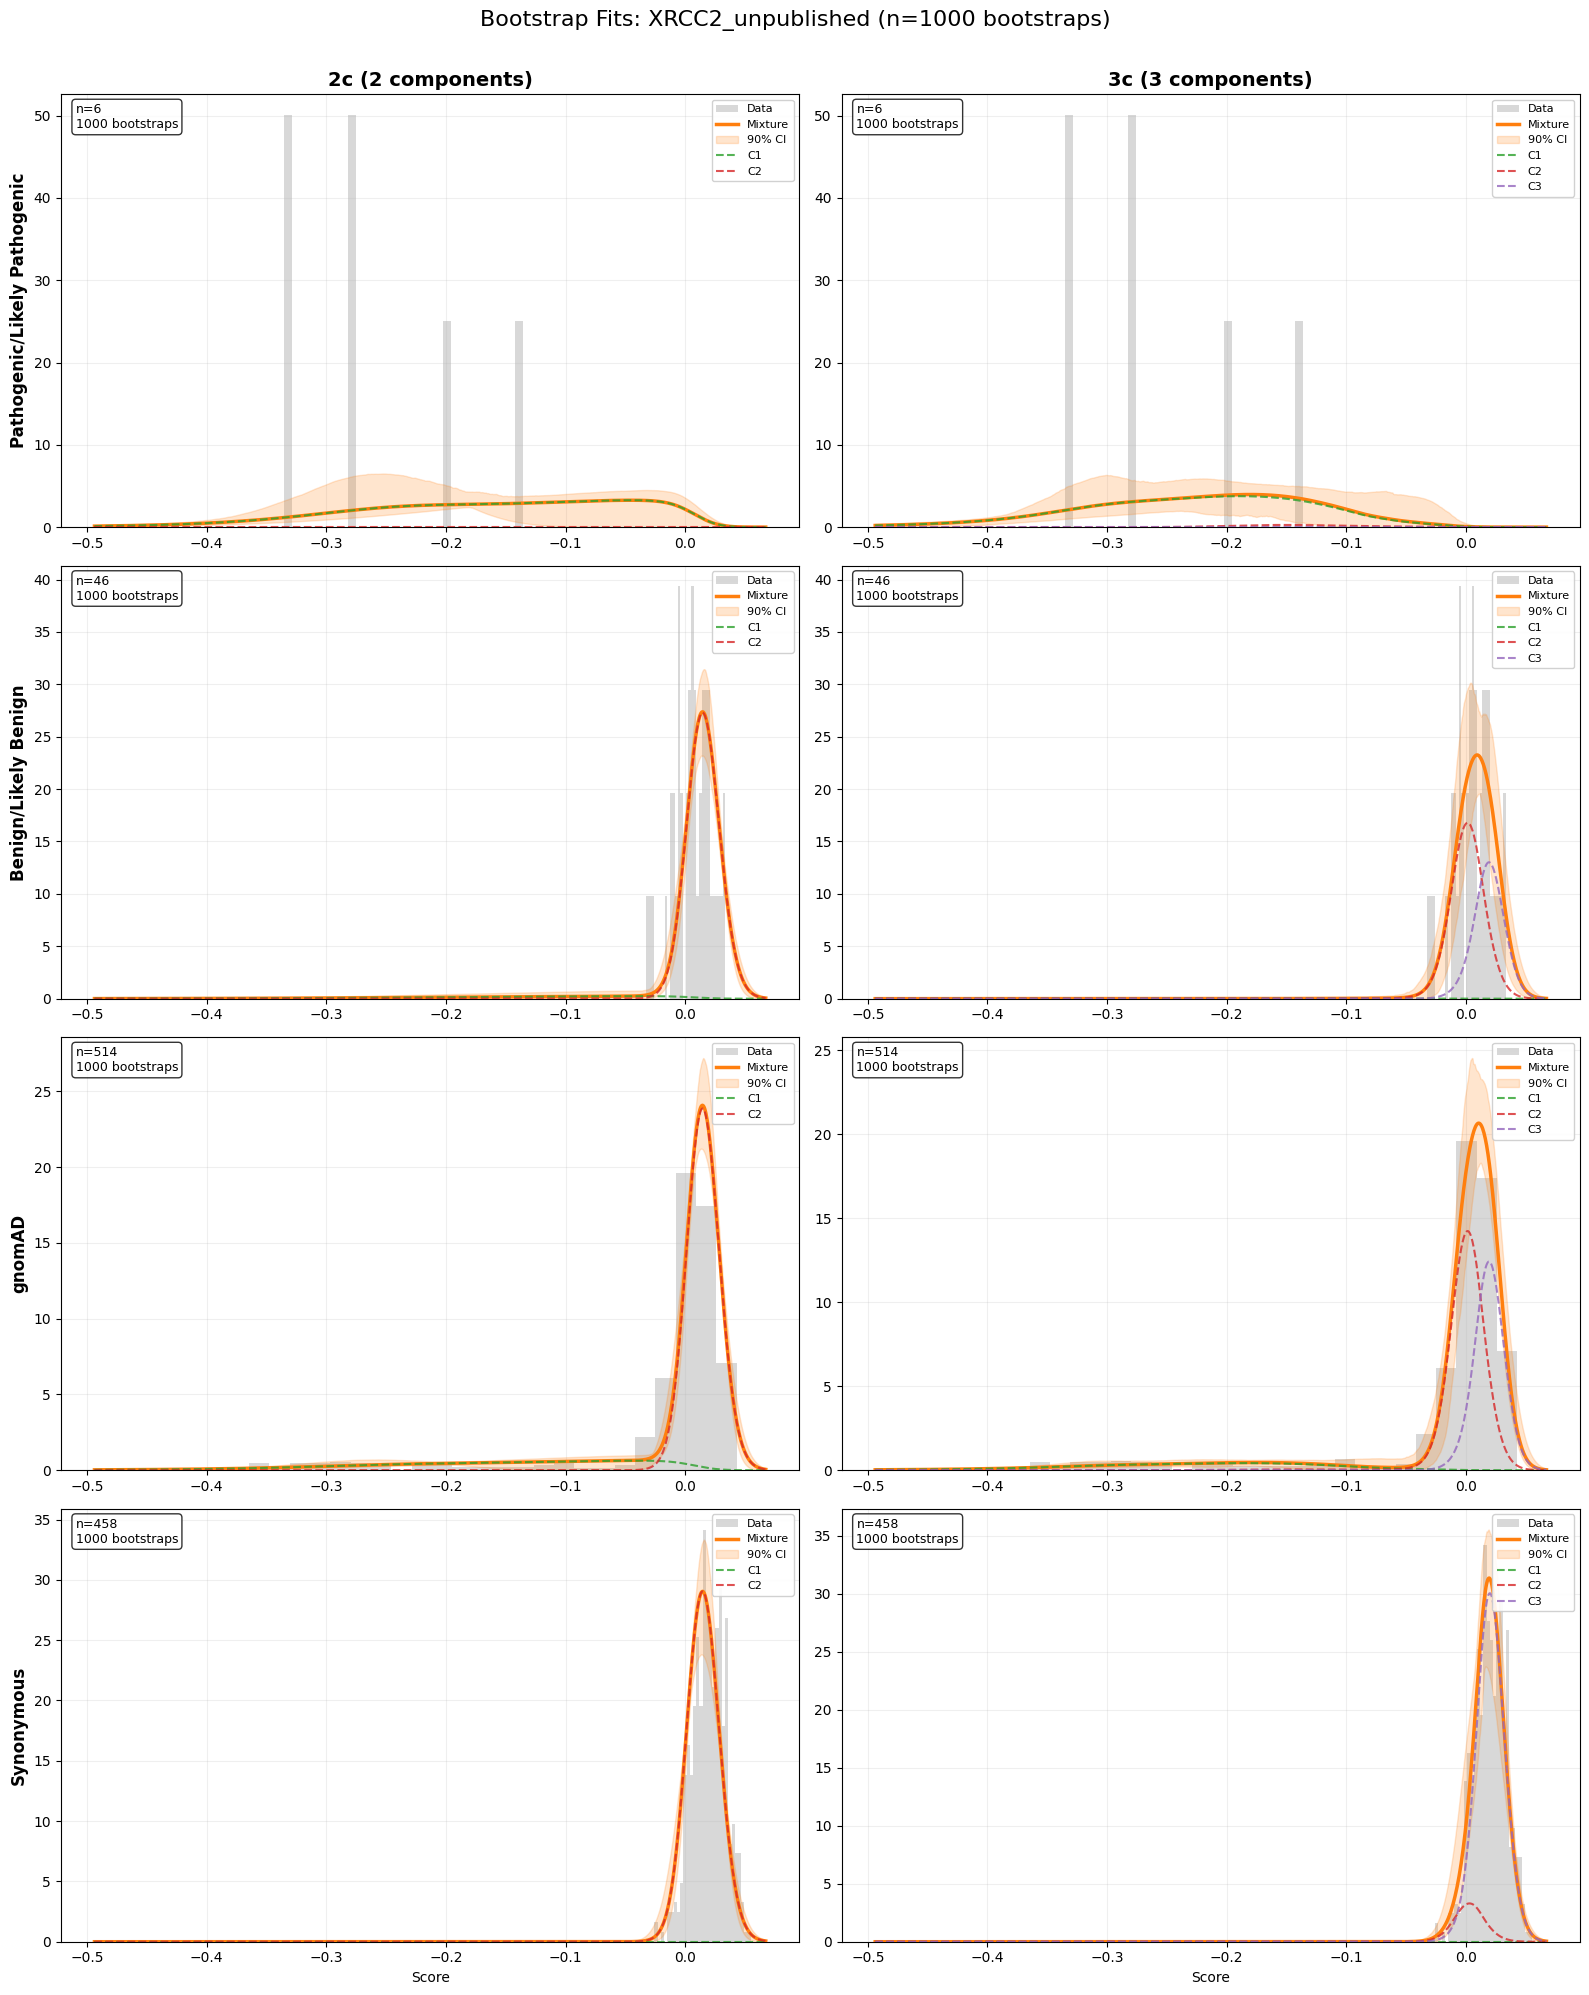

VHL_Buckley_2024: 2268 total variants
	Pathogenic/Likely Pathogenic: 198 variants
	Benign/Likely Benign: 56 variants
	gnomAD: 344 variants
	Synonymous: 375 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


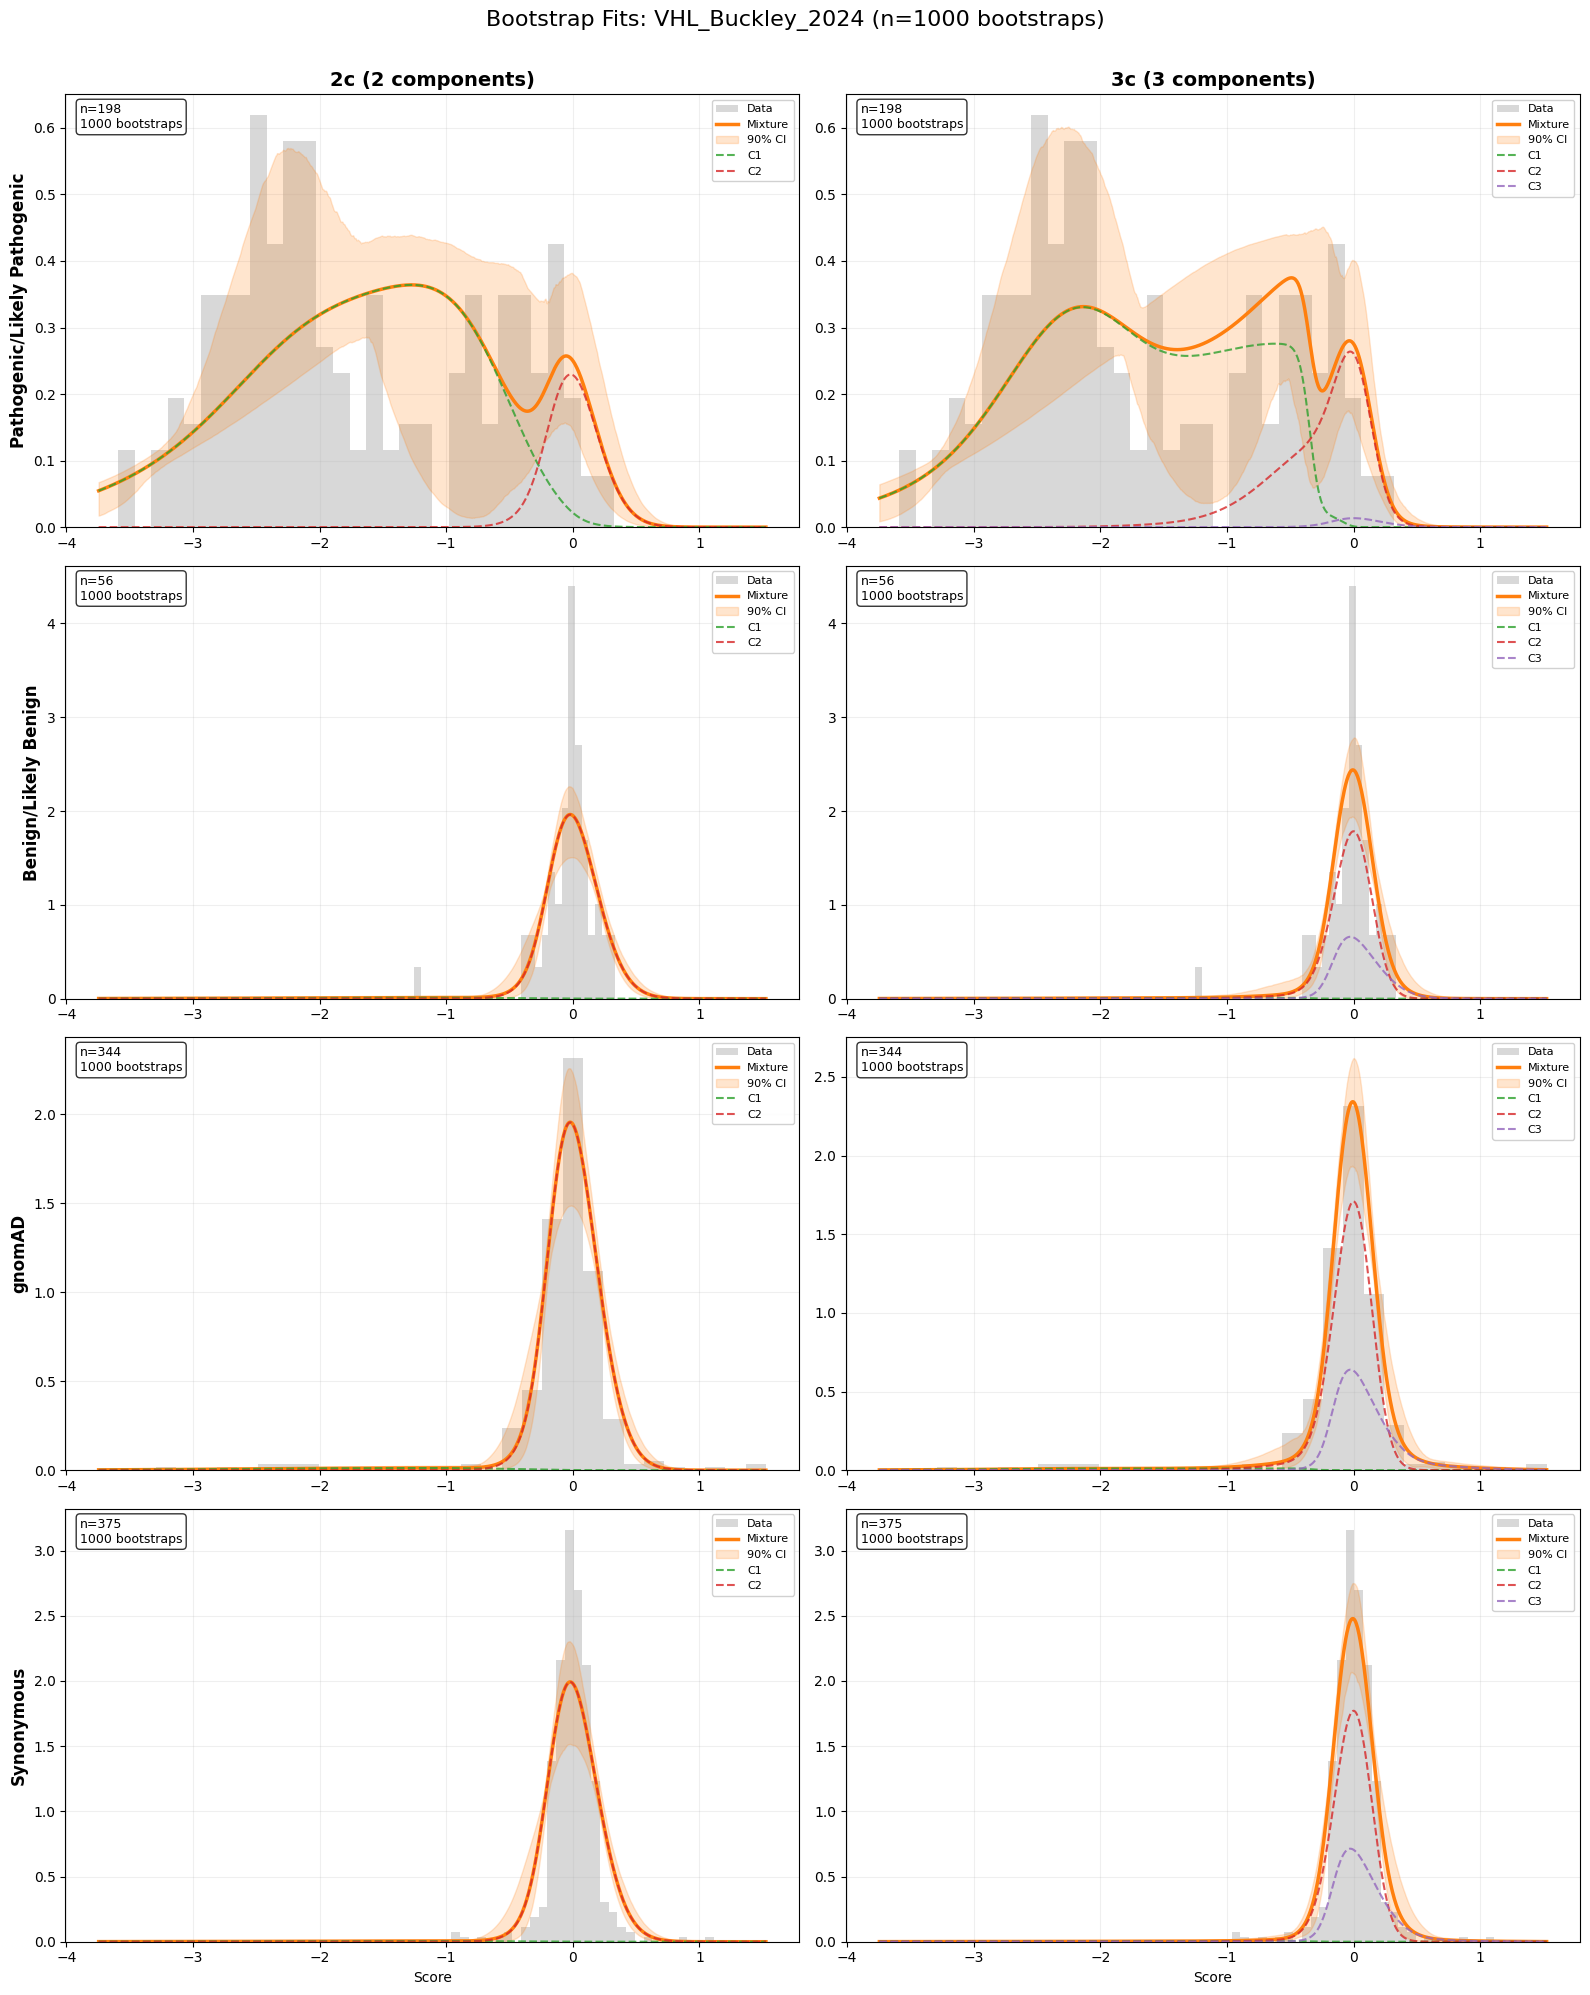

F9_Popp_2025_heavy_chain: 26988 total variants
	Pathogenic/Likely Pathogenic: 115 variants
	Benign/Likely Benign: 21 variants
	gnomAD: 229 variants
	Synonymous: 418 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


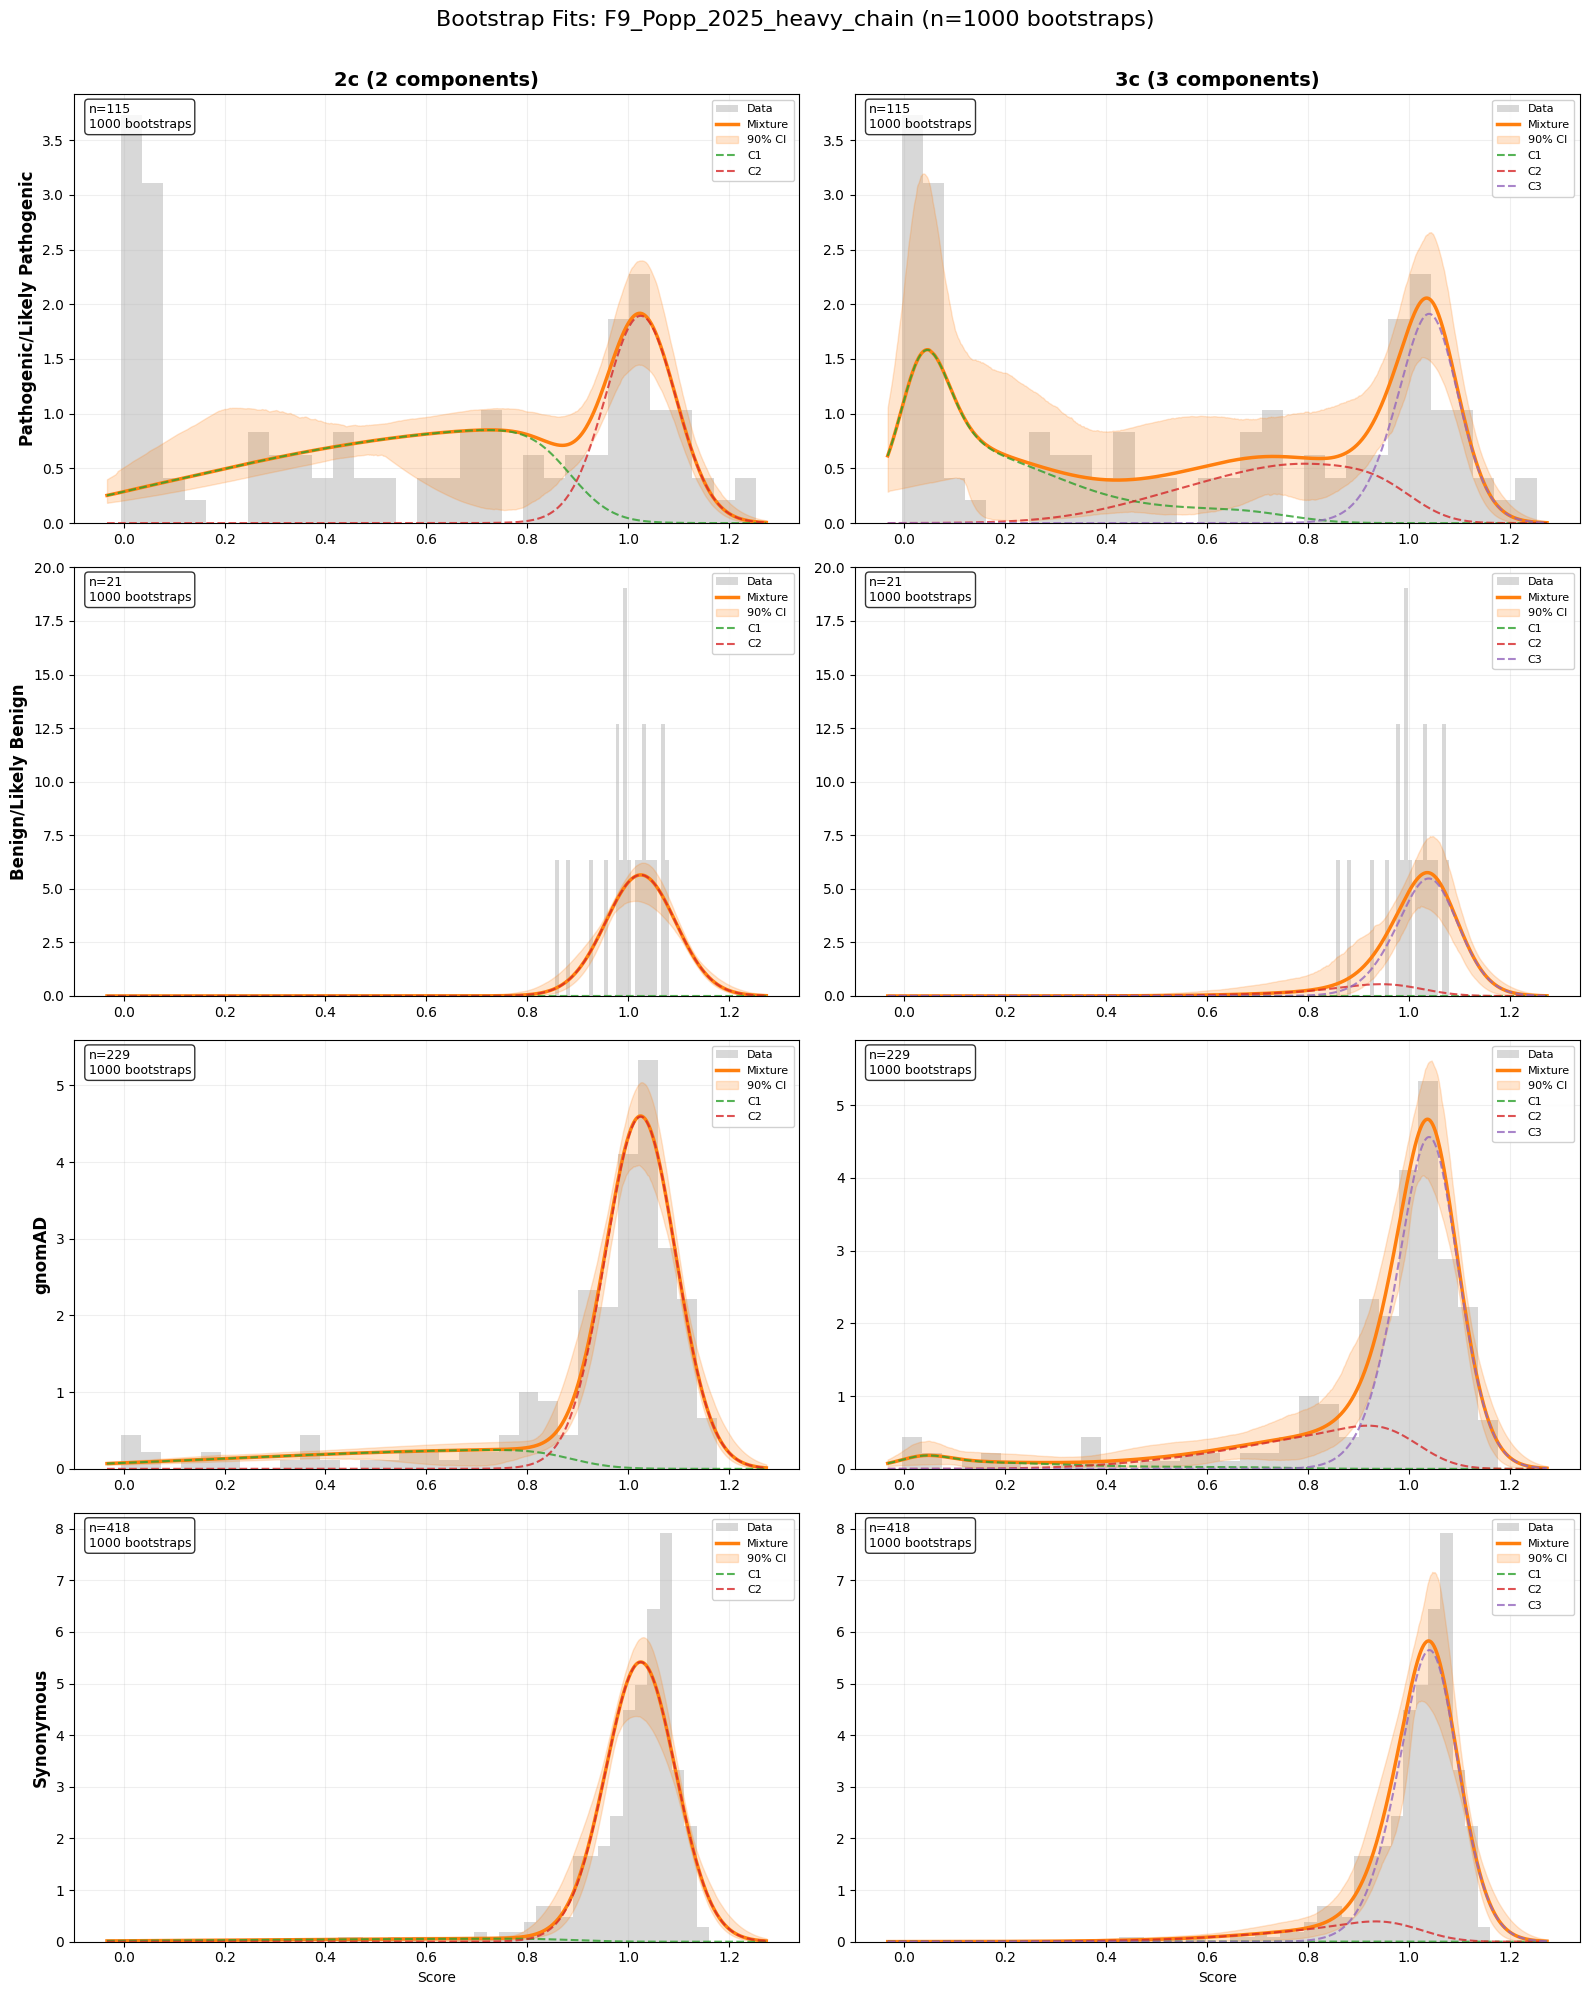

F9_Popp_2025_carboxy_F9_specific: 26988 total variants
	Pathogenic/Likely Pathogenic: 115 variants
	Benign/Likely Benign: 21 variants
	gnomAD: 229 variants
	Synonymous: 418 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


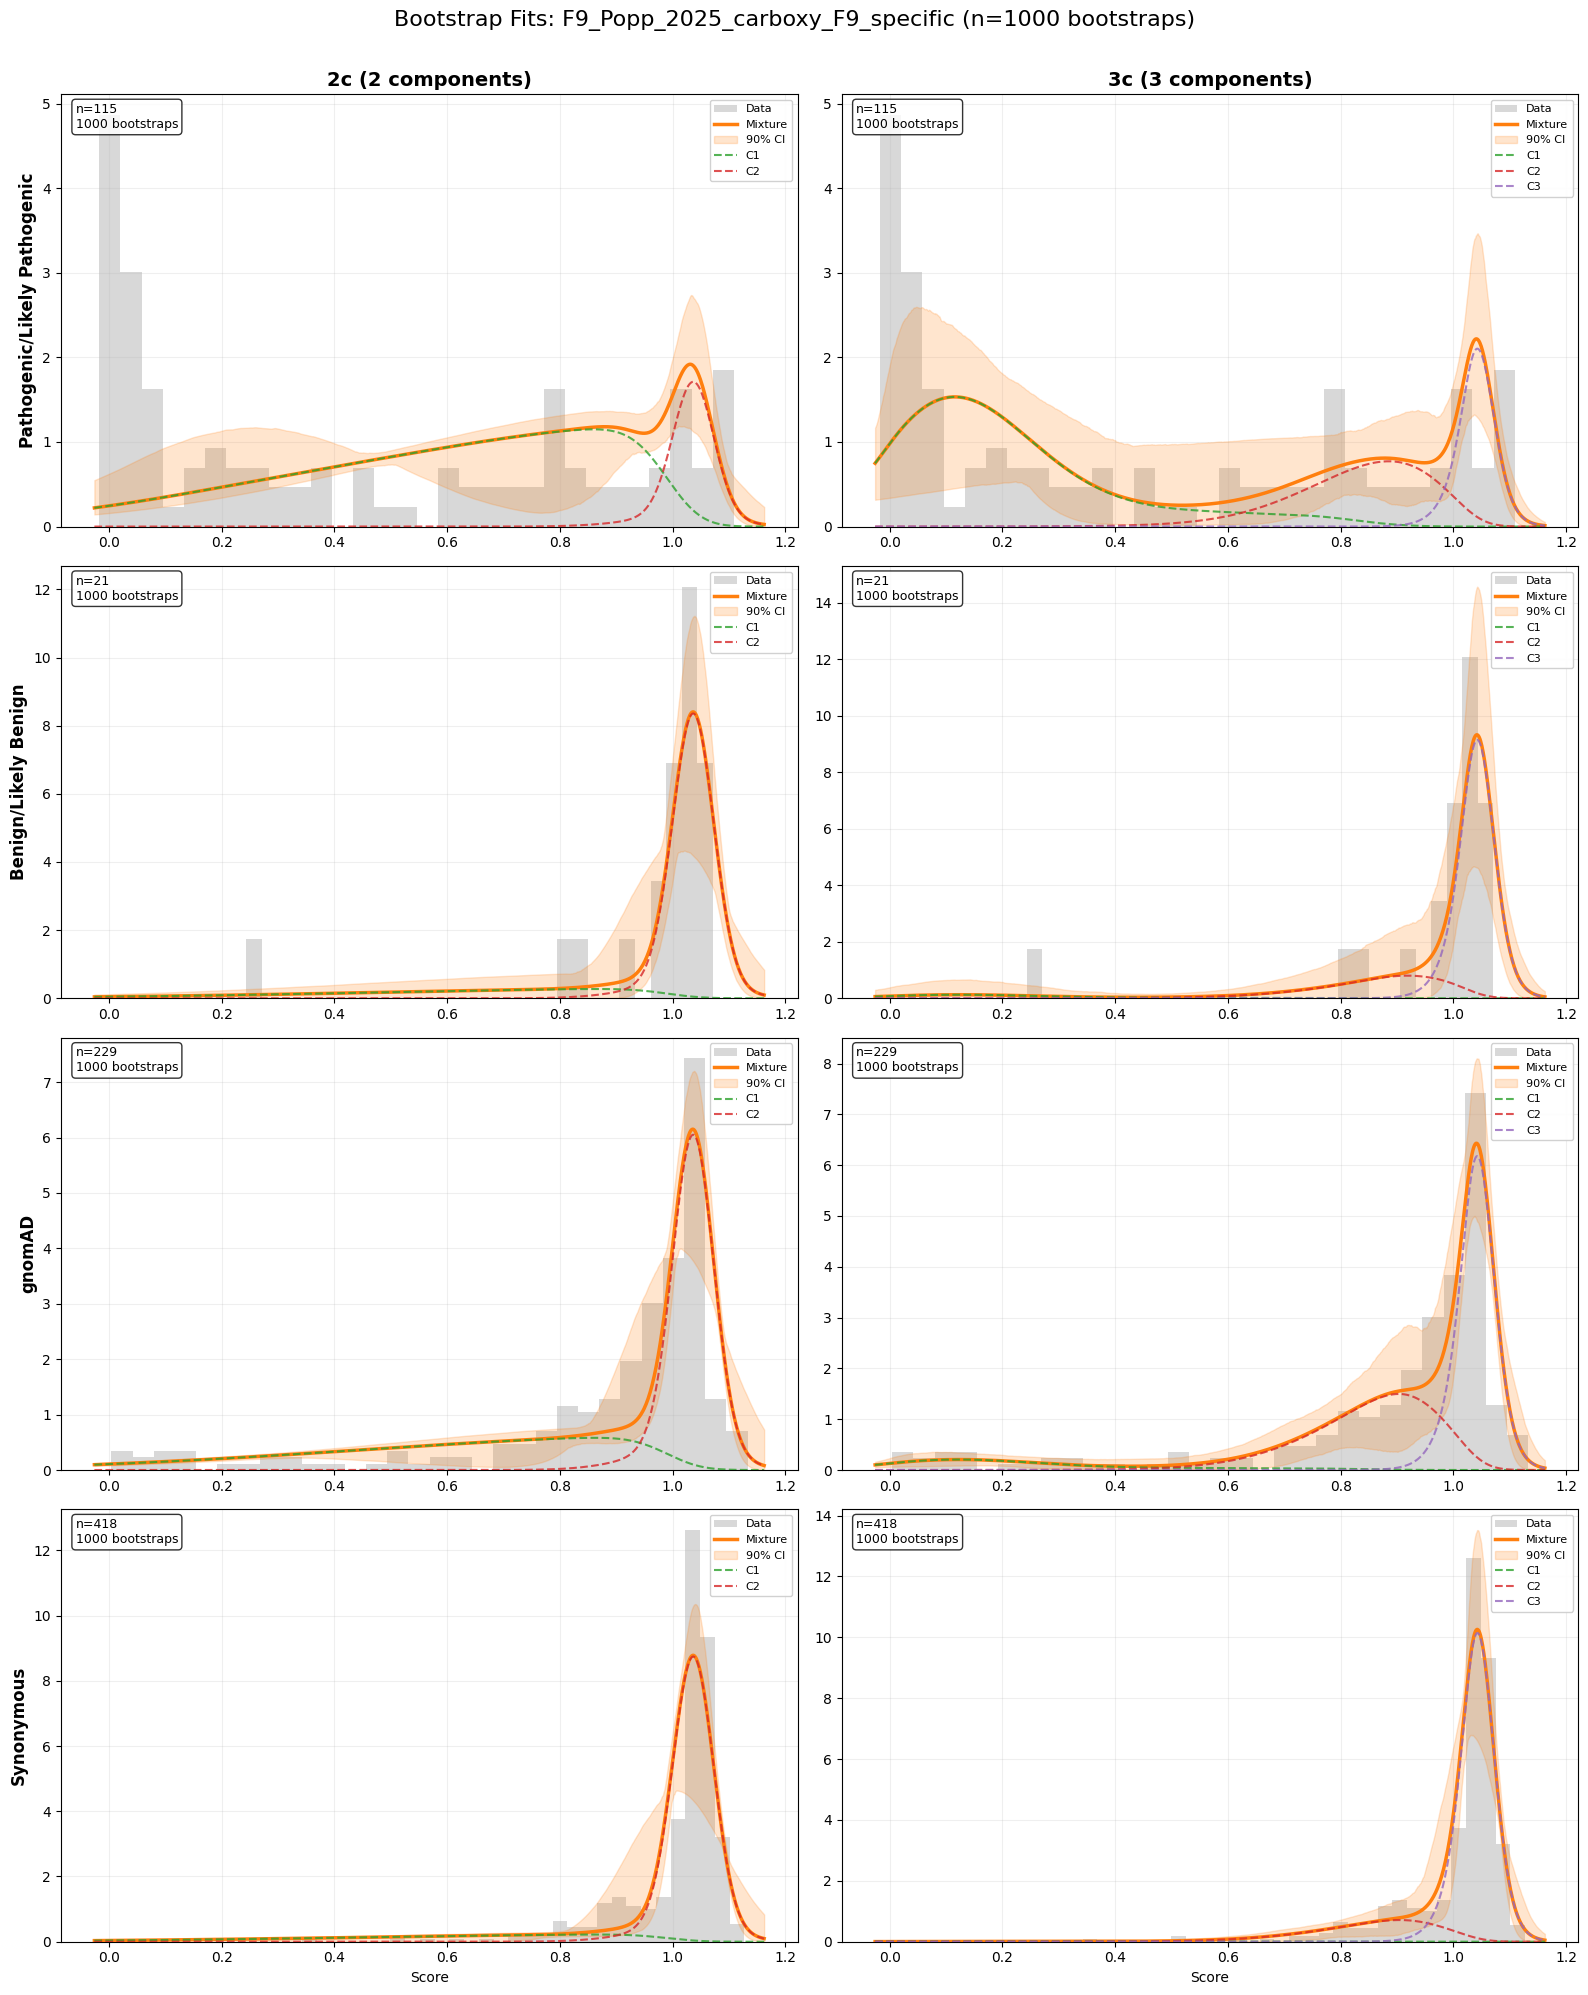

BRCA2_Sahu_2023_exon13_SGE: 251 total variants
	Pathogenic/Likely Pathogenic: 17 variants
	Benign/Likely Benign: 9 variants
	gnomAD: 46 variants
	Synonymous: 39 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


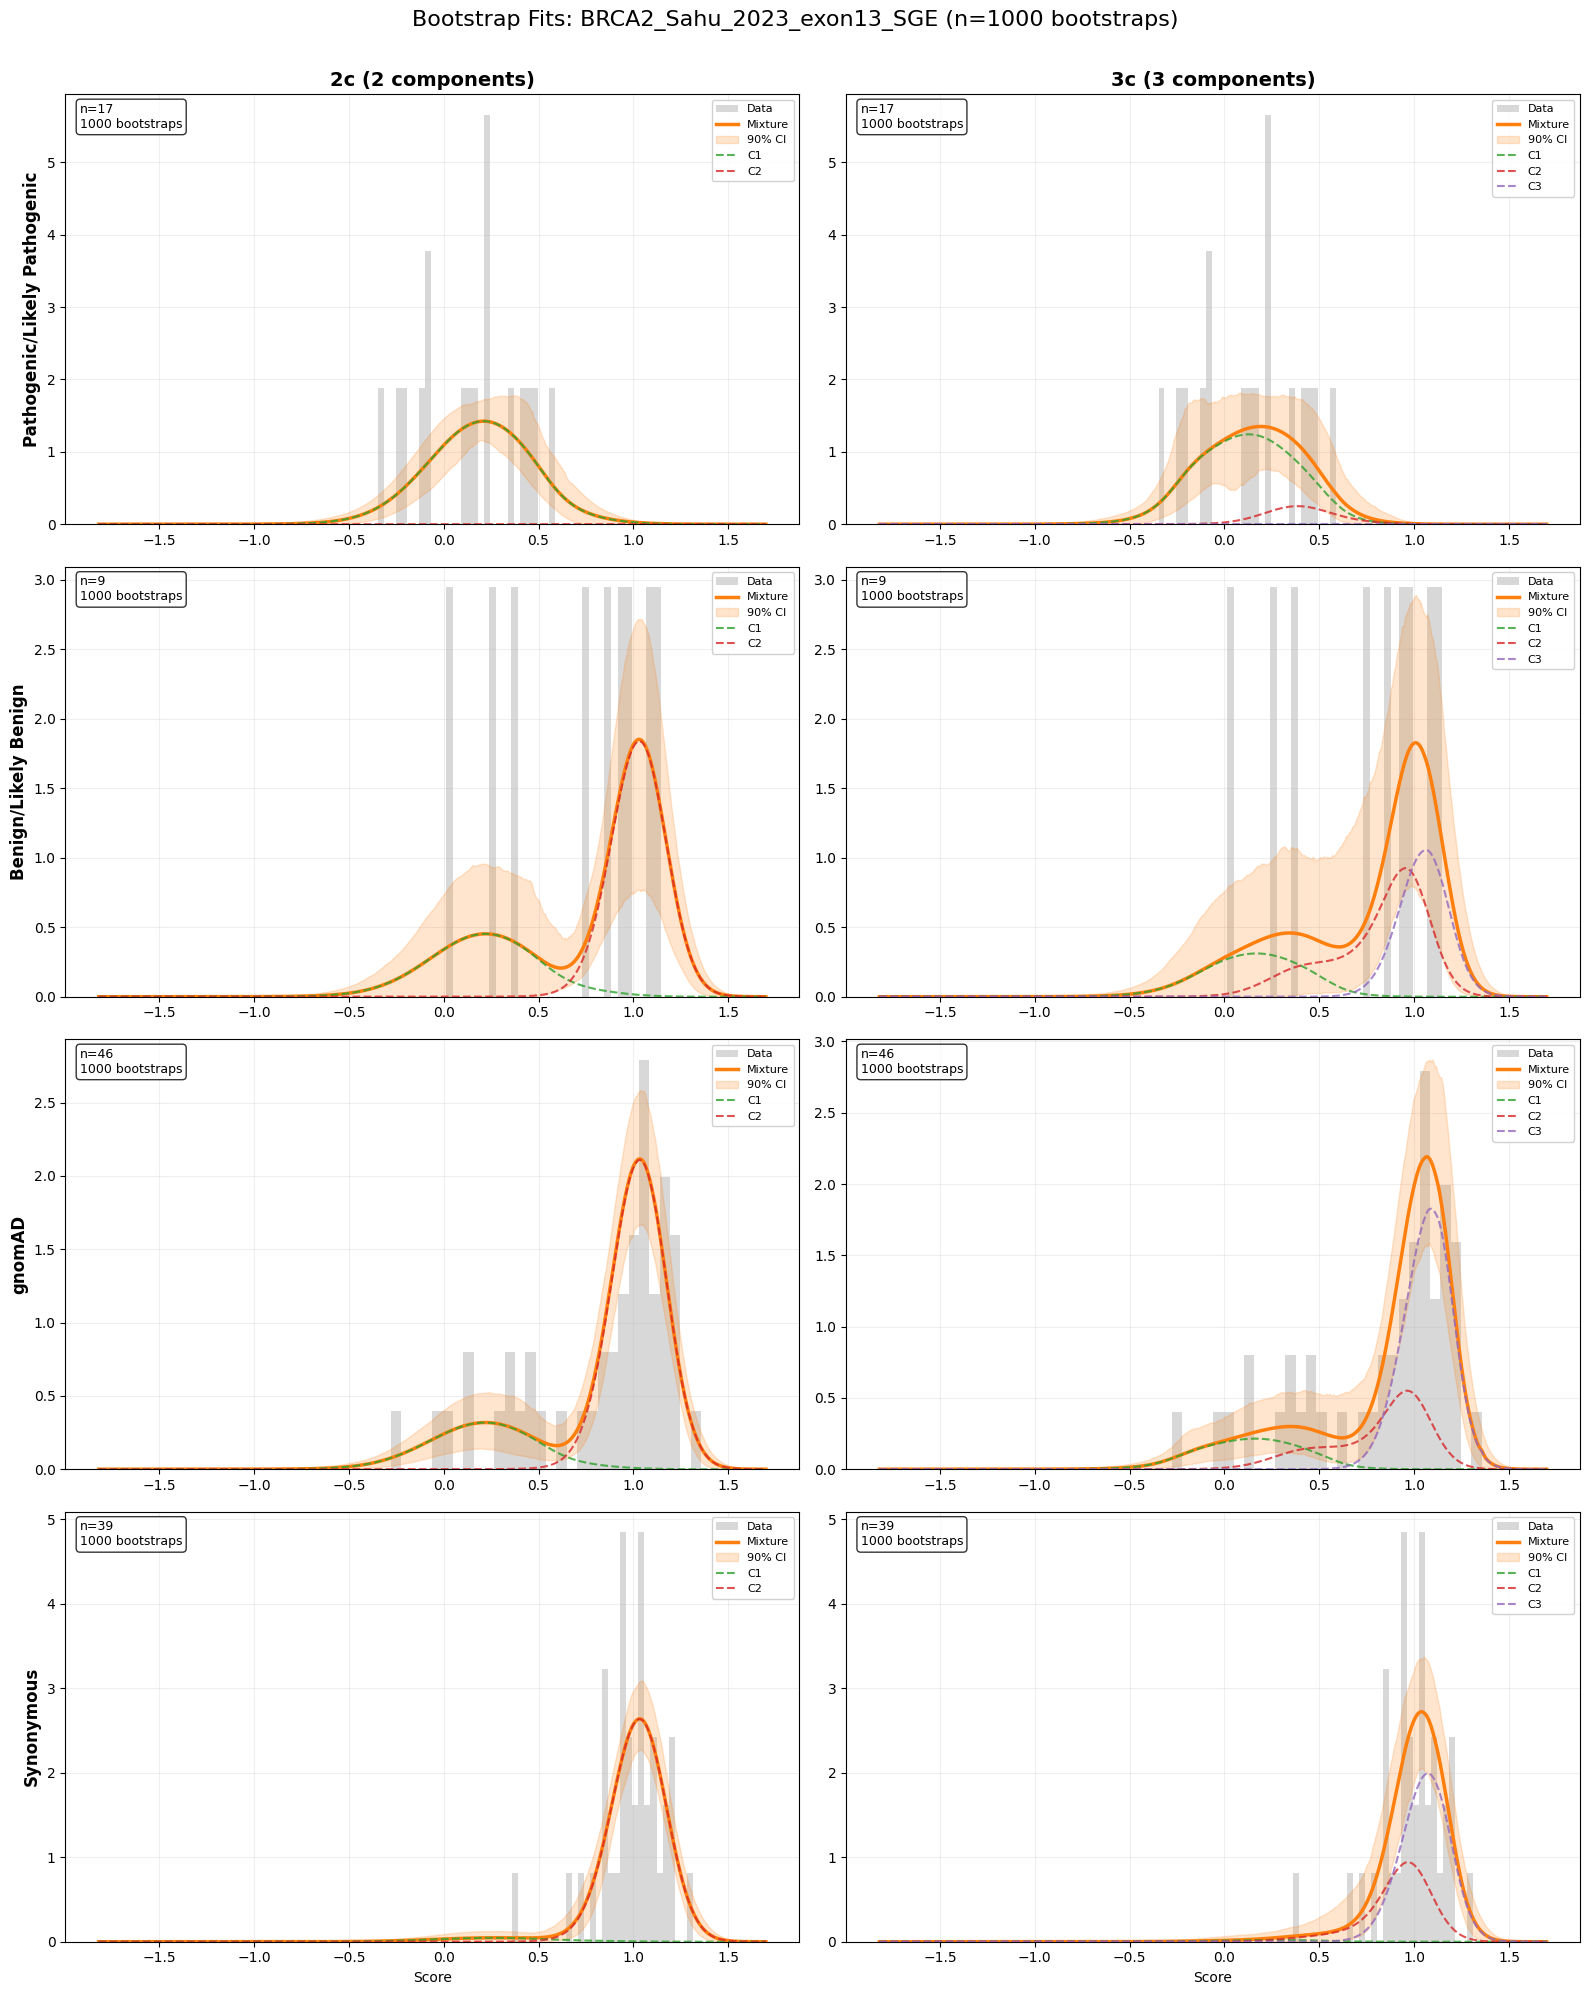

BARD1_unpublished: 9128 total variants
	Pathogenic/Likely Pathogenic: 185 variants
	Benign/Likely Benign: 270 variants
	gnomAD: 1614 variants
	Synonymous: 1337 variants

Found 1000 2c results and 1000 3c results
2c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 2, 1000)
2c mean_densities shape: (4, 1000)
3c shapes - all_densities: (1000, 4, 1000), all_component_densities: (1000, 4, 3, 1000)
3c mean_densities shape: (4, 1000)


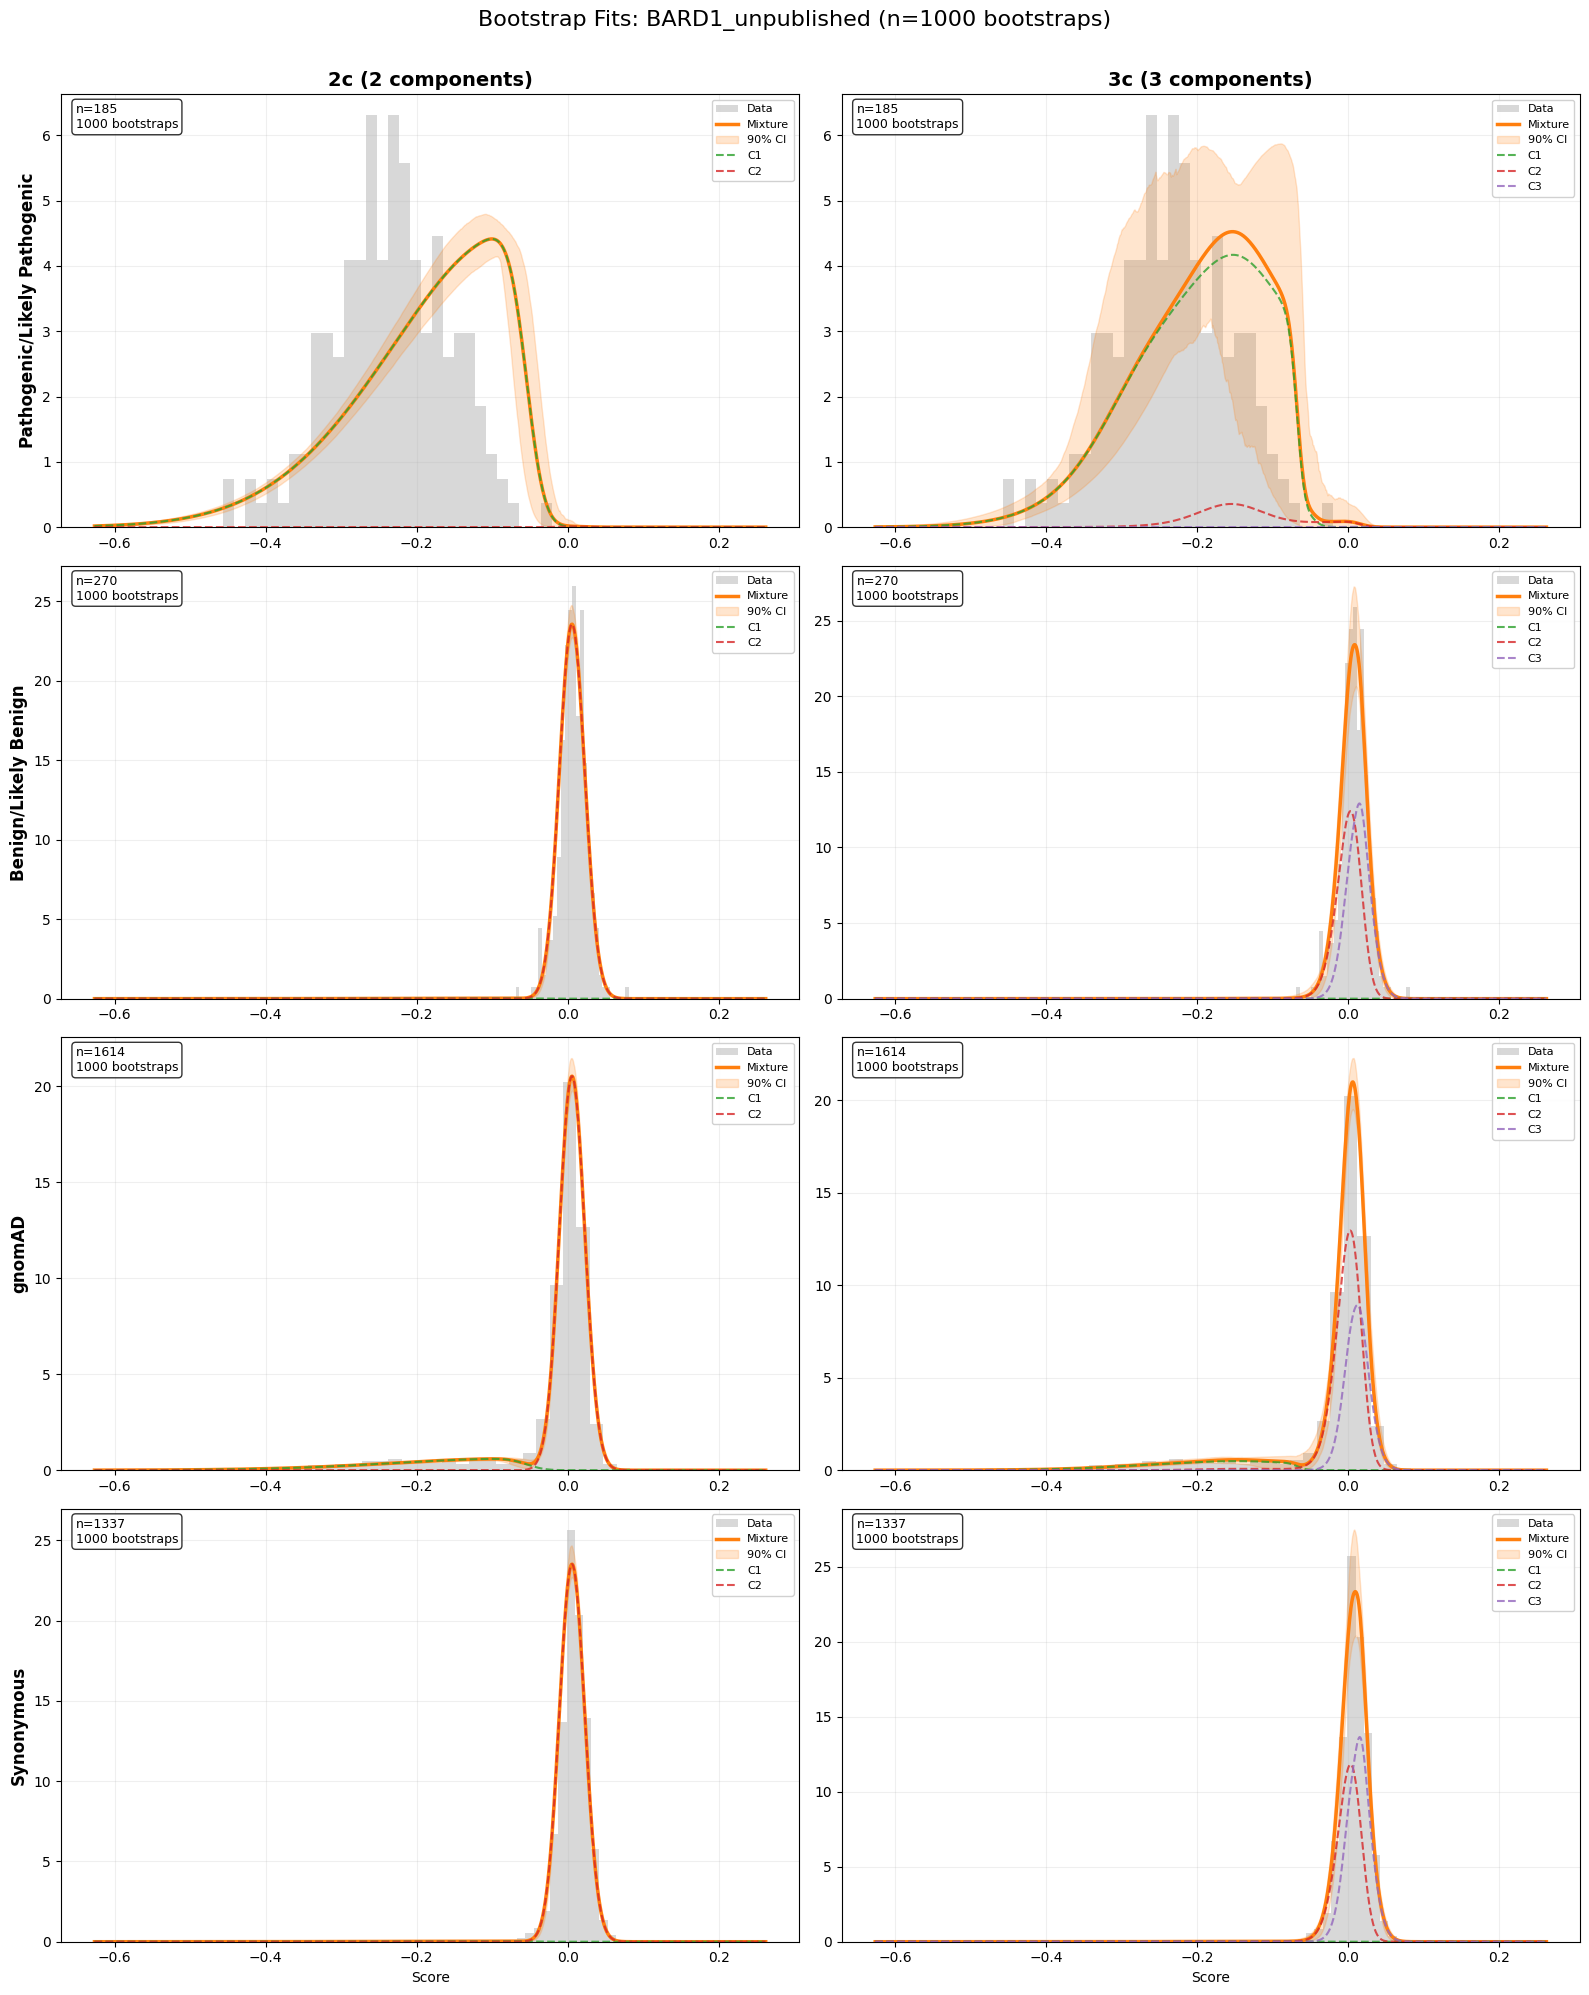

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_bootstrap_fits(bootstrap_results, dataset_name, sample_names, scores, sample_assignments, save_dir):
    """
    Plot 2c and 3c fits with bootstrap variance
    
    Args:
        bootstrap_results: Dict of bootstrap results
        dataset_name: Name of the dataset
        sample_names: List of sample names
        scores: Array of scores
        sample_assignments: Sample assignment matrix
    """
    # Separate 2c and 3c results
    results_2c = [bootstrap_results[str(i)]['2c'] for i in range(1000) if str(i) in bootstrap_results]
    results_3c = [bootstrap_results[str(i)]['3c'] for i in range(1000) if str(i) in bootstrap_results]
    
    print(f"Found {len(results_2c)} 2c results and {len(results_3c)} 3c results")
    
    # Create figure
    n_samples = len(sample_names)
    if n_samples == 0:
        return None
    fig, axes = plt.subplots(n_samples, 2, figsize=(16, 5*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle(f'Bootstrap Fits: {dataset_name} (n={len(bootstrap_results)} bootstraps)', 
                 fontsize=16, y=0.995)
    
    # Score range for density calculation
    score_range = np.linspace(scores.min(), scores.max(), 1000)
    
    # Process both 2c and 3c
    for fit_idx, (results_list, fit_type) in enumerate([(results_2c, '2c'), (results_3c, '3c')]):
        
        if len(results_list) == 0:
            print(f"No {fit_type} results, skipping")
            continue
        
        # Collect all densities from bootstrap samples
        all_densities = []  # [n_bootstraps, n_samples, n_scores]
        all_component_densities = []  # [n_bootstraps, n_samples, n_components, n_scores]
        
        for boot_idx, boot_result in enumerate(results_list):
            fit = boot_result['fit']
            component_params = fit['component_params']
            weights = fit['weights']
            
            # Calculate densities for each sample
            sample_densities = []
            sample_component_densities = []
            
            for sample_weights in weights:
                try:
                    # Joint density (mixture)
                    joint_dens = density_utils.joint_densities(
                        score_range[..., None],
                        component_params,
                        sample_weights
                    ).squeeze()
                    
                    # Ensure correct shape [n_components, n_scores]
                    if joint_dens.ndim == 1:
                        # Single component case
                        joint_dens = joint_dens.reshape(1, -1)
                    elif joint_dens.shape[1] != len(score_range):
                        # Might need transpose
                        joint_dens = joint_dens.T
                    
                    sample_densities.append(joint_dens.sum(0))  # Sum over components -> [n_scores]
                    sample_component_densities.append(joint_dens)  # Keep components -> [n_components, n_scores]
                    
                except Exception as e:
                    print(f"Error in bootstrap {boot_idx}, sample: {e}")
                    continue
            
            if len(sample_densities) > 0:
                all_densities.append(sample_densities)
                all_component_densities.append(sample_component_densities)
        
        if len(all_densities) == 0:
            print(f"No valid densities for {fit_type}")
            continue
        
        # Convert to numpy arrays
        try:
            all_densities = np.array(all_densities)  # [n_bootstraps, n_samples, n_scores]
            all_component_densities = np.array(all_component_densities)  # [n_bootstraps, n_samples, n_components, n_scores]
        except Exception as e:
            print(f"Error stacking arrays for {fit_type}: {e}")
            print(f"all_densities shapes: {[np.array(d).shape for d in all_densities[:3]]}")
            continue
        
        print(f"{fit_type} shapes - all_densities: {all_densities.shape}, all_component_densities: {all_component_densities.shape}")
        
        # Validate shapes
        if all_densities.ndim < 2:
            print(f"Invalid dimensions for {fit_type}, skipping")
            continue
        
        # Calculate statistics
        mean_densities = np.mean(all_densities, axis=0)  # [n_samples, n_scores]
        std_densities = np.std(all_densities, axis=0)
        
        print(f"{fit_type} mean_densities shape: {mean_densities.shape}")

        show_CI = True
        n_components = 2 if fit_type == '2c' else 3
        
        try:
            percentile_05 = np.percentile(all_densities, 5, axis=0)
            percentile_95 = np.percentile(all_densities, 95, axis=0)
            
            # Component-wise statistics
            if all_component_densities.ndim >= 3:
                n_components = all_component_densities.shape[2]
                mean_component_densities = np.mean(all_component_densities, axis=0)  # [n_samples, n_components, n_scores]
                std_component_densities = np.std(all_component_densities, axis=0)
            else:
                print(f"Component densities have wrong shape: {all_component_densities.shape}")
                mean_component_densities = None
                std_component_densities = None
        
        except Exception as e:
            print(f"Error computing statistics for {fit_type}: {e}")
            show_CI = False
            mean_component_densities = None
            std_component_densities = None
        
        # Plot for each sample
        for sample_idx in range(n_samples):
            ax = axes[sample_idx, fit_idx] if n_samples > 1 else axes[fit_idx]
            
            # Plot histogram of actual data
            if sample_idx < sample_assignments.shape[1] and sample_assignments[:, sample_idx].sum() > 0:
                sample_data = scores[sample_assignments[:, sample_idx]]
                ax.hist(sample_data, bins=30, density=True, alpha=0.3, 
                       color='gray', zorder=1, label='Data')
            
            # Check if we have valid data for this sample
            if sample_idx >= mean_densities.shape[0]:
                print(f"Sample {sample_idx} out of range for {fit_type}")
                continue
            
            # Plot mean mixture density
            ax.plot(score_range, mean_densities[sample_idx], 
                   color='C1', linewidth=2.5, label='Mixture', zorder=3)
            
            # Plot confidence interval for mixture
            if show_CI:
                ax.fill_between(score_range, 
                               percentile_05[sample_idx], 
                               percentile_95[sample_idx],
                               alpha=0.2, color='C1', label='90% CI', zorder=2)
            
            # Plot individual components with variance
            if mean_component_densities is not None:
                component_colors = ['C2', 'C3', 'C4', 'C5']
                for comp_idx in range(n_components):
                    mean_comp = mean_component_densities[sample_idx, comp_idx]
                    
                    color = component_colors[comp_idx % len(component_colors)]
                    
                    # Mean component
                    ax.plot(score_range, mean_comp, 
                           color=color, linewidth=1.5, linestyle='--',
                           label=f'C{comp_idx+1}', zorder=3, alpha=0.8)
            
            # Styling
            if fit_idx == 0:
                ax.set_ylabel(sample_names[sample_idx], fontsize=12, fontweight='bold')
            
            if sample_idx == 0:
                ax.set_title(f'{fit_type} ({n_components} components)', fontsize=14, fontweight='bold')
            
            if sample_idx == n_samples - 1:
                ax.set_xlabel('Score', fontsize=10)
            
            # Legend
            ax.legend(loc='upper right', fontsize=8, framealpha=0.9)
            ax.grid(True, alpha=0.2)
            
            # Add statistics text
            n_points = len(scores[sample_assignments[:, sample_idx]])
            stats_text = f'n={n_points}\n{len(results_list)} bootstraps'
            ax.text(0.02, 0.98, stats_text, 
                   transform=ax.transAxes, fontsize=9,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(f'{save_dir}/{dataset_name}.png', dpi=150, bbox_inches='tight')
    return fig

urgent_datasets=(
  'XRCC2_unpublished',
  'VHL_Buckley_2024',
  'F9_Popp_2025_heavy_chain',
  'F9_Popp_2025_carboxy_F9_specific',
  'BRCA2_Sahu_2023_exon13_SGE',
  'BARD1_unpublished'
)


for dataset in urgent_datasets:
    
    dataset_f = f"/data/ross/assay_calibration/scoresets/{dataset}.json"
    dataset_name = dataset_f.split('/')[-1].split('.')[0]
    
    ds = Scoreset.from_json(dataset_f)
    print(ds)
    
    sample_names = np.array([sample[1] for sample in ds.samples])
    
    
    fig = plot_bootstrap_fits(results[dataset_name], dataset_name, 
                              ds.sample_names,
                              ds.scores, ds.sample_assignments, save_dir)
    if fig is not None:
        plt.show()